In [1]:
import TensorFrost as tf
import numpy as np
import matplotlib.pyplot as plt
import time

tf.initialize(tf.opengl)

S = 512

def transpose(A):
    N, M = A.shape
    i, j = tf.indices([M, N])
    return A[j, i] * 1.0

def matmul():
    A = tf.input([-1, -1], tf.float32)
    N, M = A.shape
    B = tf.input([M, -1], tf.float32)
    K = B.shape[1]
        
    Bt = transpose(B)
    
    if(False): # This does atomics - very slow
        C = tf.zeros([N, K])
        i, j, k = tf.indices([N, K, M])
        tf.scatterAdd(C[i, j], A[i, k] * Bt[j, k])
    else: # This does a loop - much faster
        C = tf.buffer([N, K])
        i, j = C.indices
        s = tf.zeros([N, K], tf.float32)
        def loop_body(k):
            s.set(s + A[i, k] * Bt[j, k])
        tf.loop(loop_body, 0, M, 1)
        C[i, j] = s
        
    return [C]

mmul = tf.compile(matmul)

TensorFrost module loaded!
matmul:
  Kernel count: 2
  Intermediate buffers: 1
  Host readbacks: 0
  Host writes: 0
  Lines of generated code: 368
  IR Compile time: 0.487000 ms
  Compiler time: 1386.453613 ms



In [2]:
Anp = np.random.rand(64, 32).astype(np.float32)
Bnp = np.random.rand(32, 48).astype(np.float32)

A = tf.tensor(Anp)
B = tf.tensor(Bnp)
C, = mmul(A, B)

Cnp = C.numpy

#compare to numpy
Cnp2 = Anp @ Bnp

print(Cnp)
print(Cnp2)

Cerror = np.linalg.norm(Cnp - Cnp2) / np.linalg.norm(Cnp2)
print("Error:", Cerror)


[[7.3399234 6.9677687 8.337198  ... 8.5025625 8.846307  8.125247 ]
 [8.000398  6.2878895 7.4323993 ... 8.637445  7.816068  8.33611  ]
 [7.477689  5.778774  8.26234   ... 7.463405  7.867641  7.0117974]
 ...
 [6.9680696 5.0844593 7.712008  ... 6.5078654 7.705628  7.5888963]
 [7.5285697 5.113137  8.015706  ... 7.9065237 7.853799  9.009134 ]
 [5.970255  5.675243  7.303898  ... 7.8782644 7.2294235 7.1292467]]
[[7.3399224 6.9677696 8.337198  ... 8.502563  8.846306  8.125247 ]
 [8.000398  6.2878895 7.4323983 ... 8.637446  7.8160677 8.336109 ]
 [7.477689  5.7787733 8.262339  ... 7.4634047 7.867642  7.011796 ]
 ...
 [6.968069  5.0844584 7.7120075 ... 6.507866  7.7056284 7.588896 ]
 [7.5285697 5.113137  8.015707  ... 7.906522  7.853799  9.009135 ]
 [5.970255  5.6752424 7.3038974 ... 7.8782654 7.2294235 7.1292467]]
Error: 4.7012648e-08


In [3]:
Anp = np.random.rand(S, S).astype(np.float32)
Bnp = np.random.rand(S, S).astype(np.float32)

A = tf.tensor(Anp)
B = tf.tensor(Bnp)

def TestFunc(f1, max_time):
    t0 = time.time()
    i = 0
    while time.time() - t0 < max_time:
        f1()
        i += 1
    return (time.time() - t0) / i

# Performance test
def TensorFrost():
    C, = mmul(A, B)

def Numpy():
    Cnp2 = Bnp @ Anp

np_time = TestFunc(Numpy, 4)
print("Numpy: ", np_time)

tf_time = TestFunc(TensorFrost, 4)
print("TensorFrost: ", tf_time)

print("TF/NP: ", tf_time / np_time)

Numpy:  0.0009414245168246447
TensorFrost:  2.9107722227658857e-05
TF/NP:  0.030918806242519636


In [4]:
# Test performance with different matrix sizes

def test_size(S):
    Anp = np.random.rand(S, S).astype(np.float32)
    Bnp = np.random.rand(S, S).astype(np.float32)

    A = tf.tensor(Anp)
    B = tf.tensor(Bnp)

    # Performance test
    def TensorFrost():
        C, = mmul(A, B)
    
    def Numpy():
        Cnp2 = Bnp @ Anp

    tf_time = TestFunc(TensorFrost, 1)
    np_time = TestFunc(Numpy, 1)

    return tf_time, np_time

sizes = [2**i for i in range(4, 12)]
tf_times = []
np_times = []

for S in sizes:
    tf_time, np_time = test_size(S)
    tf_times.append(tf_time)
    np_times.append(np_time)

    

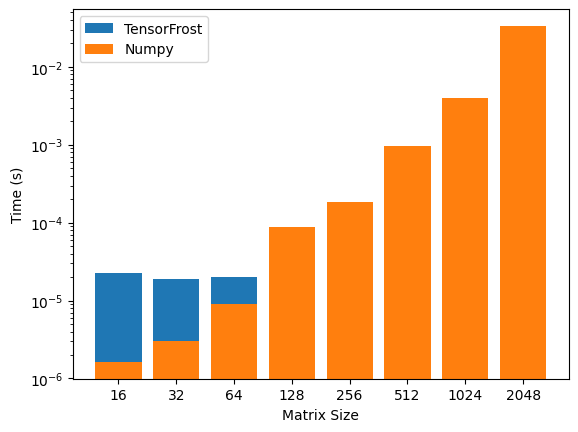

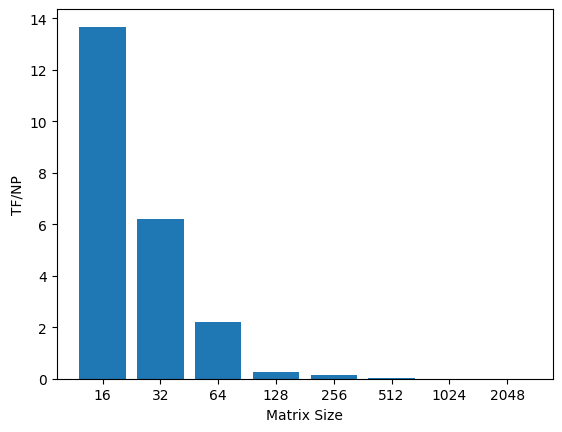

[2.2307378018996624e-05, 1.8874375179631045e-05, 2.0149968215611553e-05, 2.190943319370549e-05, 2.3775453418281306e-05, 2.5918121363580154e-05, 3.187752499290954e-05, 3.3153277380117396e-05]
[1.6307122993727984e-06, 3.0465155974031493e-06, 9.062052870261546e-06, 8.820138720019041e-05, 0.00018615058705776552, 0.0009661840355914572, 0.003933339960434858, 0.03360002835591634]


In [5]:
# Bar plot
size_str = [str(s) for s in sizes]
plt.bar(size_str, tf_times, label="TensorFrost")
plt.bar(size_str, np_times, label="Numpy")
plt.legend()
plt.xlabel("Matrix Size")
plt.ylabel("Time (s)")
plt.yscale("log")
plt.show()

# Bar plot with ratio
size_str = [str(s) for s in sizes]
plt.bar(size_str, [tf_times[i] / np_times[i] for i in range(len(sizes))])
plt.xlabel("Matrix Size")
plt.ylabel("TF/NP")
plt.show()


print(tf_times)
print(np_times)